# Machine Learning - Classification

In [4]:
import pandas as pd
import numpy as np

In [5]:
hr = pd.read_csv('https://raw.githubusercontent.com/skathirmani/datasets/master/HR%20Analytics.csv')
hr.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
hr.shape

(1470, 35)

In [7]:
hr['Attrition'].unique()

array([1, 0])

### Identify balanced or imbalanced class?

In [8]:
hr['Attrition'].value_counts() / hr.shape[0] * 100

0    83.877551
1    16.122449
Name: Attrition, dtype: float64

No. of people who left the organization is very less compared to employees who are staying. This is imbalanced class

### Converting categorical columns to numerical columns

In [9]:
hr_dummies = pd.get_dummies(hr)

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(hr_dummies,
                               test_size=0.3,
                               random_state=100)

### Gini impurity
- Formula = 1 - Prob(0)^2 - Prob(1)^2
- If you have more class in target variable, include probability of all the classes

In [11]:
n_s = train.shape[0]

p_0 = train[train['Attrition']==0].shape[0] / n_s
p_1 = train[train['Attrition']==1].shape[0] / n_s
gi_train = 1 - np.square(p_0) - np.square(p_1)
gi_train

0.27190862461880494

## Gini impurity on binary categorical columns

In [12]:
samples_left = train[train['Gender_Female']==0]
#print(samples_left.shape)
samples_right = train[train['Gender_Female']==1]
#print(samples_right.shape)

#print('--------MALE---------')
#print(samples_left[samples_left['Attrition'] == 0].shape)
#print(samples_left[samples_left['Attrition'] == 1].shape)

#print('--------FEMALE---------')
#print(samples_right[samples_right['Attrition'] == 0].shape)
#print(samples_right[samples_right['Attrition'] == 1].shape)


left_zero = samples_left[samples_left['Attrition'] == 0].shape[0]
left_one = samples_left[samples_left['Attrition'] == 1].shape[0]

rgt_zero = samples_right[samples_right['Attrition'] == 0].shape[0]
rgt_one = samples_right[samples_right['Attrition'] == 1].shape[0]

gi_left = 1 - np.square(left_zero/samples_left.shape[0]) - np.square(
    left_one/samples_left.shape[0]
)

gi_right = 1 - np.square(rgt_zero/samples_right.shape[0]) - np.square(
    rgt_one/samples_right.shape[0]
)

print(gi_left, gi_right)

gi_overall = (samples_left.shape[0]/train.shape[0]*gi_left) + \
             (samples_right.shape[0] / train.shape[0]*gi_right)
gi_overall

0.2850040311744155 0.2521516737772056


0.27162683219537664

In [13]:
uniq_mi = np.unique(train['MonthlyIncome'])
sort_mi = pd.Series(np.sort(uniq_mi))
midpoints_mi = sort_mi.rolling(2).mean().dropna()
cuts = midpoints_mi

In [14]:
df_gi_cuts = pd.DataFrame(columns=['cut', 'gi'])
for cut in cuts:
    col = 'MonthlyIncome'
    Ns = train.shape[0]
    s_left = train[train[col] < cut]
    s_right = train[train[col] > cut]
    
    p0_left = s_left[s_left['Attrition']==0].shape[0] / s_left.shape[0]
    p1_left = s_left[s_left['Attrition']==1].shape[0] / s_left.shape[0]
    gi_left = 1 - np.square(p0_left) - np.square(p1_left)


    p0_right = s_right[s_right['Attrition']==0].shape[0] / s_right.shape[0]
    p1_right = s_right[s_right['Attrition']==1].shape[0] / s_right.shape[0]
    gi_right = 1 - np.square(p0_right) - np.square(p1_right)

    gi_cut = (s_left.shape[0] / Ns * gi_left) + \
             (s_right.shape[0]/ Ns * gi_right)
    
    df_gi_cuts = df_gi_cuts.append({'cut': cut, 'gi': gi_cut},
                                  ignore_index=True)
df_gi_cuts.sort_values(by='gi').head(5)

,cut,gi
202,2779.5,0.254494
203,2781.5,0.254687
185,2693.5,0.254709
143,2489.5,0.254749
199,2766.0,0.254780


In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=100, max_depth=1)
model.fit(train[['MonthlyIncome']], train['Attrition'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [16]:
def draw_tree(model, columns):
    import pydotplus
    from sklearn.externals.six import StringIO
    from IPython.display import Image
    import os
    from sklearn import tree
    
    graphviz_path = 'C:\Program Files (x86)\Graphviz2.38/bin/'
    os.environ["PATH"] += os.pathsep + graphviz_path

    dot_data = StringIO()
    tree.export_graphviz(model,
                         out_file=dot_data,
                         feature_names=columns)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

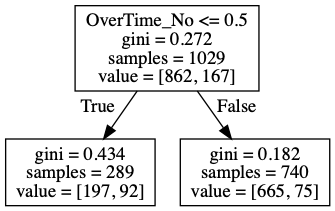

In [17]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=100, max_depth=1)
input_columns = ['MonthlyIncome', 'OverTime_No', 'Gender_Female']
model.fit(train[input_columns], train['Attrition'])
draw_tree(model, input_columns)

## Calcuate Accuracy
- It is a biased model

In [18]:
pred = model.predict(test[input_columns])
pred_prob = pd.DataFrame(model.predict_proba(test[input_columns]),
                         columns=['Prob_0', 'Prob_1'])

from sklearn.metrics import accuracy_score
accuracy_score(test['Attrition'], pred)

0.8412698412698413

In [20]:
(test['Attrition'] == pred).sum() / test.shape[0] * 100

84.12698412698413